In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

import corner

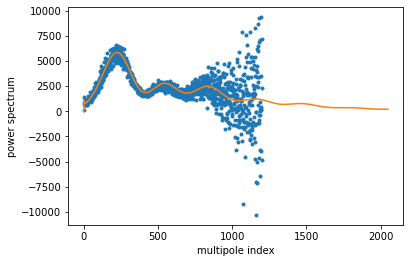

In [3]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pars_old=pars

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

In [33]:
# covA = array([[ 1.15883914e+20, -1.25935378e+23,  4.20774640e+23,
#          1.81337243e+23, -3.64354082e+32,  4.68845638e+22],
#        [-1.25935378e+23,  1.36858680e+26, -4.57271519e+26,
#         -1.97065956e+26,  3.95957192e+35, -5.09512069e+25],
#        [ 4.20774640e+23, -4.57271519e+26,  1.52783326e+27,
#          6.58435763e+26, -1.32297014e+36,  1.70237911e+26],
#        [ 1.81337243e+23, -1.97065956e+26,  6.58435763e+26,
#          2.83759797e+26, -5.70147855e+35,  7.33658130e+25],
#        [-3.64354082e+32,  3.95957192e+35, -1.32297014e+36,
#         -5.70147855e+35,  1.14557658e+45, -1.47411161e+35],
#        [ 4.68845638e+22, -5.09512069e+25,  1.70237911e+26,
#          7.33658130e+25, -1.47411161e+35,  1.89686580e+25]])


# covA = [[ 5.39916412e+01,  7.92117770e-03,  8.67746996e-32,
#          6.65990261e-02,  1.29349241e-10,  1.32518018e-01],
#        [ 7.92117770e-03,  4.19145611e-06,  8.66668475e-36,
#          1.93968238e-05,  1.81007558e-13,  4.37705371e-05],
#        [ 8.67746996e-32,  8.66668475e-36,  4.81482486e-35,
#          1.46370676e-34, -1.89410711e-42, -3.08148791e-34],
#        [ 6.65990261e-02,  1.93968238e-05,  1.46370676e-34,
#          2.51228071e-04,  1.64388891e-12,  3.11719469e-04],
#        [ 1.29349241e-10,  1.81007558e-13, -1.89410711e-42,
#          1.64388891e-12,  1.59002197e-20,  2.09392667e-12],
#        [ 1.32518018e-01,  4.37705371e-05, -3.08148791e-34,
#          3.11719469e-04,  2.09392667e-12,  5.97713424e-04]]

covA = np.eye(6)

# print(covA)

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ. What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

In [4]:
def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))
    return y

def our_chisq(data,pars):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    x=data[0]
    y=data[1]
    noise=data[2]
    
    #set chi to inf if tau is negative to not get these terms
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)[2:]

        chisq=np.sum( (y-model)**2/noise**2)
    return chisq


#put this stuff in somewhere ones i have the matrix
# coVarMatrix = np.diag(wmap[:,2]**2)

# r = np.linalg.cholesky(coVarMatrix);

# d = np.dot(r, np.random.randn(r.shape[0]))
# print(d)

In [5]:
# cmb=wmap_camb_example.get_spectrum(pars)

def run_mcmc(pars, data, par_step, chifun, nstep=5000):
    
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    
    chi_cur=chifun(data,pars)
#     L = np.linalg.cholesky(covA);   
    # d = np.dot(r, np.random.randn(r.shape[0])).    
    
    for i in range(nstep):
        
        pars_trial=pars+np.random.randn(npar)*par_step 
#         pars_trial=pars+L@np.random.randn(npar) #for using corvar for steps

        chi_trial=chifun(data,pars_trial)
        
        #we now have chi^2 at our current location
        #and chi^2 in our trial location. decide if we take the step
        accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
        
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
        
        if i%100==0:
            print("{:.2f} ".format(i/nstep), end = '')
    print("done")
    return chain,chivec

In [ ]:
#y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]

x=np.linspace(1,10,1801)
print(len(x), x[-1])

#get starting points with newton's method?

# par_sigs=np.asarray([0.01,0.01,0.01,0.01])
par_sigs=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])/100

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
#could start using results from NM
pars_guess=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

data=[wmap[:,0], wmap[:,1], wmap[:,2]]

chain,chivec=run_mcmc(pars_guess, data, par_sigs, our_chisq, nstep=2000)

#cut off burn in
pars_sigs_new=np.std(chain,axis=0)
pars_new=np.mean(chain,axis=0)

print(pars_sigs_new)

1801 10.0
0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 

[7.74582705e+01 2.28622693e-02 1.00000000e-01 4.61784255e-02
 1.92903218e-09 9.80243121e-01]


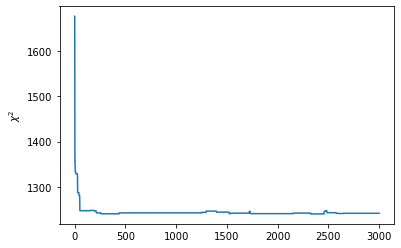

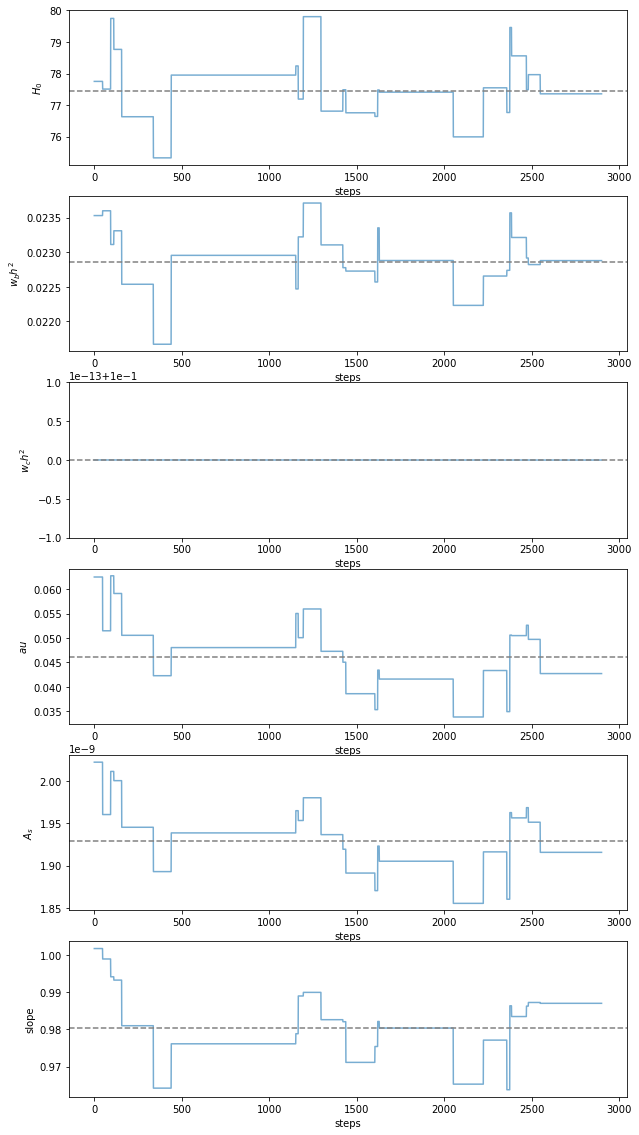

In [15]:
pars_new=np.mean(chain[20:,:], axis=0)
print(pars_new)

variables = ['$H_0$', '$w_bh^2$', '$w_ch^2$', '$\tau$', '$A_s$', 'slope']

paths = np.transpose(chain)

# plt.semilogy(chivec)
plt.plot(chivec[0:])

plt.ylabel("$\chi^2$")
plt.show()

fig, ax = plt.subplots(6, 1, figsize=(10,20))
axs = ax.flatten()

for i, vchain in enumerate(paths):
    axs[i].plot(vchain[100:], alpha=0.6)
#     axs[i].set_title(variables[i])
    axs[i].axhline(pars_new[i], color='grey', ls="--", label="std")
    axs[i].set_xlabel('steps')
    axs[i].set_ylabel(variables[i])

plt.show()

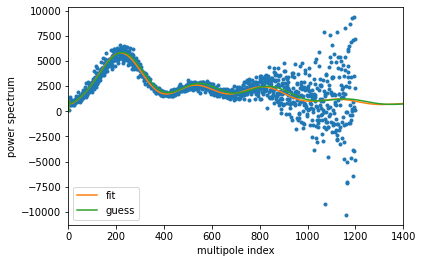

In [18]:
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb_newfit=wmap_camb_example.get_spectrum(pars_new)
cmb_old=wmap_camb_example.get_spectrum(pars_old)

plt.plot(cmb_newfit, label="fit")
plt.plot(cmb_old, label="guess")

plt.xlabel("multipole index")
plt.ylabel("power spectrum")
plt.xlim(0, 1400)
plt.legend()

plt.show()

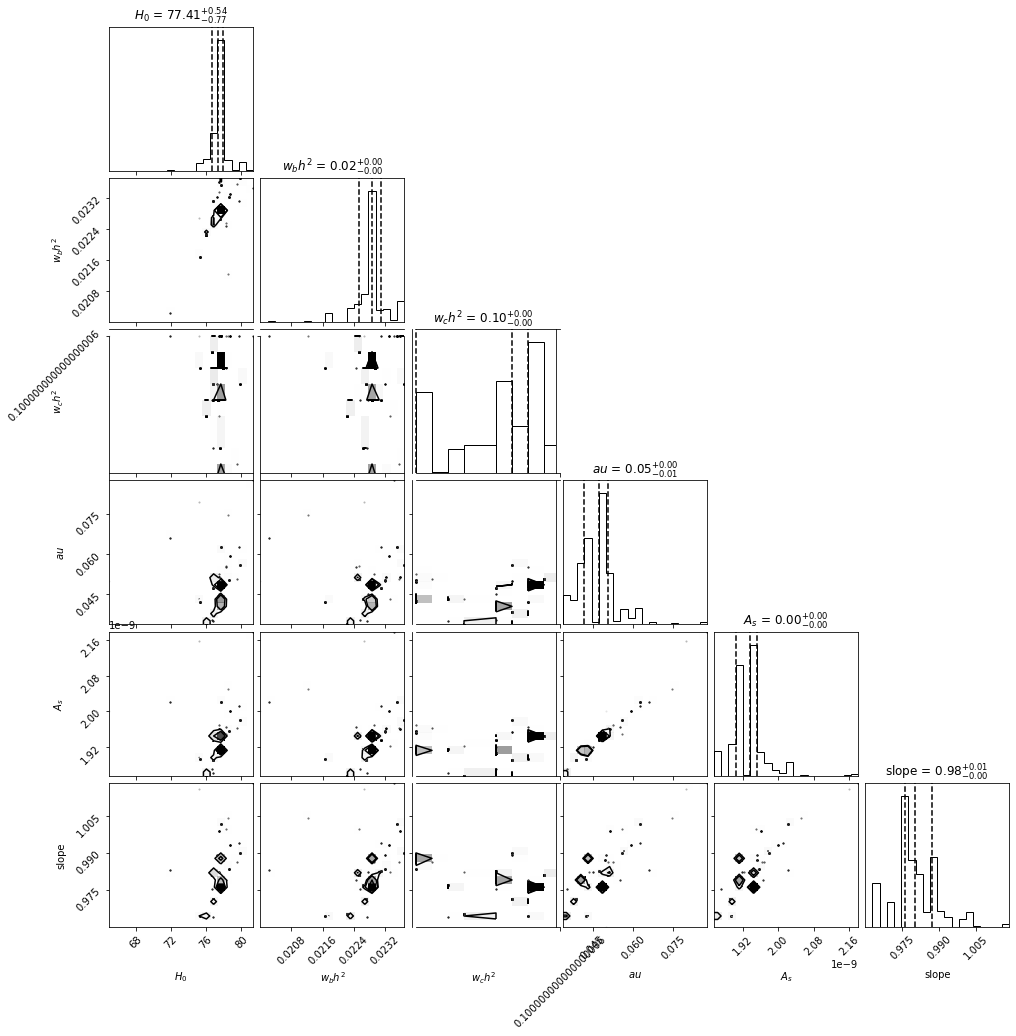

In [23]:
figure = corner.corner(chain, labels=variables, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

In [11]:
numChains = 4
allChains = []

for i in range(numChains):
    print("Chain ", i)
    par_sigs=pars_sigs_new

    #[H_0, w_bh2, w_ch2, tau, A_s, slope]
    pars_guess=pars_new+3*par_sigs*np.random.randn(len(pars_guess))
    print("Initial: ", pars_guess)

    chain,chivec=run_mcmc(pars_guess, data, par_sigs, our_chisq, nstep=1000)
    allChains.append(chain)

#     #cut off burn in
#     pars_sigs_new=np.std(chain,axis=0)
#     pars_new=np.mean(chain,axis=0)

Chain  0
Initial:  [7.31127751e+01 1.98751149e-02 1.21864514e-01 5.63512117e-02
 1.98311756e-09 9.89887489e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  1
Initial:  [6.90634920e+01 2.14991405e-02 1.23096419e-01 6.14097816e-02
 1.81261473e-09 9.11556657e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  2
Initial:  [6.50154852e+01 2.22465549e-02 1.01517305e-01 5.58769501e-02
 2.09042113e-09 9.50399774e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  3
Initial:  [5.83002770e+01 1.96104450e-02 1.15844212e-01 6.97531888e-02
 2.08805643e-09 1.03150609e+00]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done


In [13]:
for i in range(numChains):
    for j in range(i+1, numChains):
    
        #gonna need to do this for each parameter
        #also get rid of burn in
        mean1 = np.mean(allChains[i], axis=0)
        mean2 = np.mean(allChains[j], axis=0)     
        std1 = np.std(allChains[i], axis=0)
        std2 = np.std(allChains[j], axis=0)   
        
        print("diff in sigma: ", (mean1-mean2)/(0.5*(std1-std2)))
        

diff in sigma:  [  8.06920585   2.82127646  19.21866318 -63.82969308   2.98565326
   0.90599678]
diff in sigma:  [ -2.75910847  -4.39730209   3.05451404   6.20024992 -26.25891734
 -20.05274559]
diff in sigma:  [-2.42483374 -1.9426714   0.26907906 -2.77877193 85.31598714 -1.20199374]
diff in sigma:  [ 4.14316559  8.74333249 -4.40521386 26.62792602  7.48504314  2.30904596]
diff in sigma:  [-222.43731249   -7.00440907   31.17736773    8.13528987    1.87828467
  -26.70880201]
diff in sigma:  [ -2.54245614  -1.20049002   3.44218733 -21.13898641 -38.5919984
  -0.04231705]


In [14]:
# https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/
# astrophysics/public/icic/data-analysis-workshop/2018/Convergence-Tests.pdf

means = []
stds = []

allChains = np.array(allChains)

# print(allChains[0])

for i in range(numChains):
    #gonna need to do this for each parameter
    #also get rid of burn in
    meansPara = []
    stdPara = []

#     for k in range(len(pars_new)):
    mean1 = np.mean(allChains[i], axis=0) #might have index wrong here
    std1 = np.std(allChains[i], axis=0)
#     meansPara.append(mean1)
#     stdPara.append(std1)
    
#     print(mean1)
#     print(np.mean(allChains[i][0]))
#     print(np.mean(allChains[i,:,-1]))

    means.append(mean1)
    stds.append(std1)
    
N = len(allChains[0][0])

# print(means)

totalChainMeans = np.mean(means, axis=0) #get right axis here so get array

# print(totalChainMeans)

B = N/(numChains - 1) * np.sum((means - totalChainMeans)**2, axis=0)
W = 1/numChains * np.sum(stds, axis=0)

V = (N-1)/N * W + (numChains+1)/(numChains*N) * B

#should be ~1 for convergence
print(np.sqrt(V/W))

[1.81236091 0.91298887 0.91500634 0.93012313 0.91287093 0.9150851 ]


In [ ]:
means = np.array(means)
stds = np.array(stds)

for i in range(len(totalChainMeans)):
    
    plt.axhline(totalChainMeans[i], ls="--")
#     plt.fill_between([0, 1, 2, 3], totalChainMeans[i] + )
    plt.errorbar([0, 1, 2, 3], means[:,i], yerr=stds[:,i], marker="o", ls="", )

    plt.show()

What are your parameter limits now? Please also present an argument as to why you think your chains are converged. 

### 5) 
The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ. What are your new parameter values/constraints?    
You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?   
(p316 in tb)

In [ ]:
#do we need to do both?
#first way is easy but long, second needs rev of oct 5th lecture


#mulitply by correction to X^2